# Introduction
_____________

### Interest & Inspirations
- Is it possible to predict a daily revenue of a certain youtuber with his/her channel's daily view, subscribers gained, average viewed duration, etc...?
- Which factor is most related with increasing daily Revenue?
- How much can `Total Views of videos` devote to actual Monetizing?
- If one has more videos posted on his/her channel, would she/he happen to earn more? 


In [79]:
# %%capture
# import sys

# if 'google.colab' in sys.modules:
#     # Install packages in Colab
#     !pip install category_encoders==2.*
#     !pip install eli5
#     !pip install pandas-profiling==2.*
#     !pip install pdpbox
#     !pip install shap

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')

# Import Data
________

In [4]:
csv_names = ['Table data 2018.csv', 'Table data 2019.csv', 'Table data 2020.csv']
path = '/content/drive/MyDrive/Ai07_S2_Project/Data_youtube/'

df = pd.concat((pd.read_csv(path+csv_names[0])[1:-1], 
                pd.read_csv(path+csv_names[1])[1:-1],
               pd.read_csv(path+csv_names[2])[1:-1])).reset_index(drop=True)

df.columns = df.columns.str.replace(' ', '_')
col_map ={'Av­er­age_views_per_view­er':'Average_views_per_viewer',
          'Unique_view­ers':'Unique_viewers',
          'Av­er­age_per­cent­age_viewed_(%)':'Average_viewed',
          'Im­pres­sions':'Impressions',
          'Dis\xadlikes':'Dislikes',
          'Sub­scribers_lost':'Subscribers_lost',
          'Sub­scribers_gained':'Subscribers_gained',
          'Videos_pub­lished':'Videos_added',
          'Videos_ad­ded':'Videos_published', 
          'Sub­scribers':'Subscribers',
          'Im­pres­sions_click-through_rate_(%)':'Click_rate',
          'Com­ments_ad­ded':'Comments',
          'Watch_time_(hours)':'Watch_hours',
          'Av­er­age_view_dur­a­tion':'Average_view_sec',
          'Your_es­tim­ated_rev­en­ue_(USD)':'Revenue'}
df = df.rename(columns=col_map)
df = df.drop(['Likes_(vs._dis­likes)_(%)', 
              'Videos_added', 
              'Subscribers_lost',
              'Subscribers_gained'], axis=1)

print("2018-2020 YouTuber 'PoohinKorea' Daily Data")
print("="*45)
print('Data Size: ', df.shape)
print('Null Values: ', df.isna().sum().sum())
print('Data types: ', df.dtypes.reset_index().groupby(0).count().reset_index().values.tolist())
df.head(2)

2018-2020 YouTuber 'PoohinKorea' Daily Data
Data Size:  (1132, 16)
Null Values:  141
Data types:  [[dtype('float64'), 14], [dtype('O'), 2]]


,Date,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,0:01:51,0.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,NaN,4.0,37.0,0.9575,0:01:33,0.0


# EDA
_______

In [5]:
df.select_dtypes(include=('object')).head(2)

,Date,Average_view_sec
0,2018-08-21,0:01:51
1,2018-08-22,0:01:33


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Average_view_sec'] = pd.to_timedelta(df['Average_view_sec']).dt.seconds

In [7]:
df.isna().sum().reset_index().style.highlight_min()

,index,0
0,Date,0
1,Average_views_per_viewer,0
2,Unique_viewers,0
3,Click_rate,0
4,Impressions,0
5,Comments,0
6,Shares,0
7,Dislikes,0
8,Likes,0
9,Average_viewed,0


In [8]:
df.Videos_published.value_counts(dropna=False)

0.0    854
NaN    141
1.0    113
2.0     17
3.0      4
4.0      3
Name: Videos_published, dtype: int64

In [9]:
df.Videos_published = df.Videos_published.fillna(0.0, axis=0)
df.isna().sum().sum()

0

In [10]:
df.columns

Index(['Date', 'Average_views_per_viewer', 'Unique_viewers', 'Click_rate',
       'Impressions', 'Comments', 'Shares', 'Dislikes', 'Likes',
       'Average_viewed', 'Videos_published', 'Subscribers', 'Views',
       'Watch_hours', 'Average_view_sec', 'Revenue'],
      dtype='object')

In [11]:
df.head(2)

,Date,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,111,0.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,0.0,4.0,37.0,0.9575,93,0.0


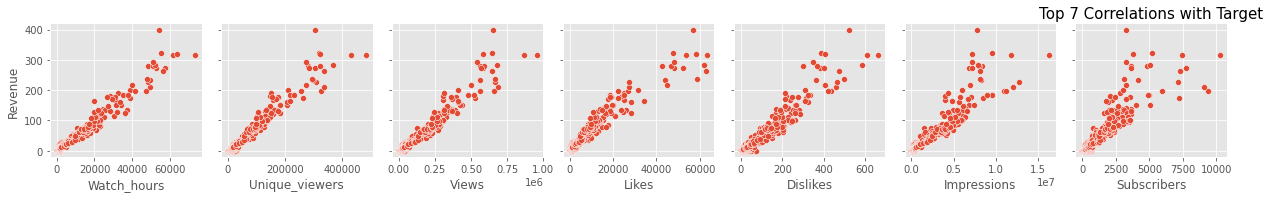

In [12]:
top_corr_name = df.corr()['Revenue'].sort_values(ascending=False).reset_index()['index'][:8].values
sns.pairplot(df[top_corr_name], x_vars=top_corr_name[1:], y_vars=top_corr_name[0])
plt.title('Top 7 Correlations with Target', fontsize=15)
plt.show()

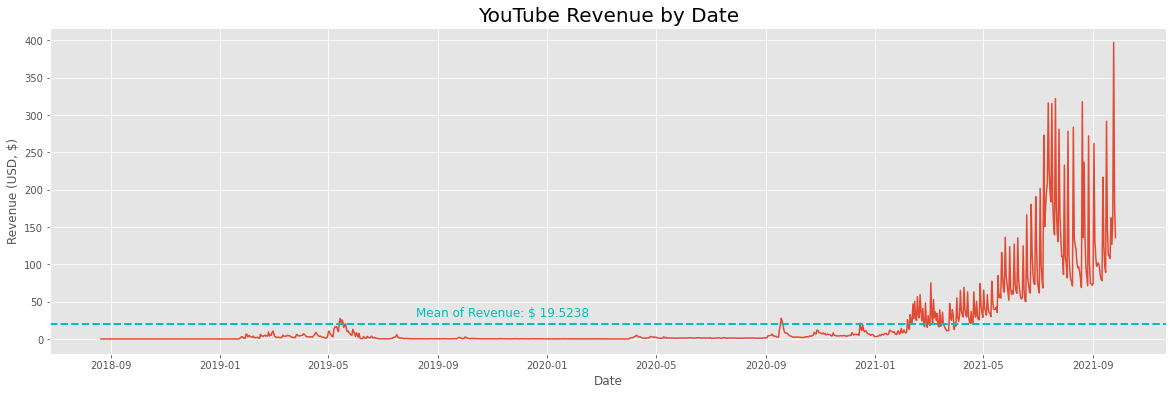

In [13]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=df, x='Date', y='Revenue')
plt.axhline(df.Revenue.mean(), color='c', linestyle='--', linewidth=2)
plt.annotate('Mean of Revenue: $ {}'.format(round(df.Revenue.mean(),4)), 
             (df.Date[350], 30), 
             fontsize=12, 
             color='c')
plt.title('YouTube Revenue by Date', fontsize=20)
plt.ylabel('Revenue (USD, $)')
plt.show()

In [14]:
df.corr()['Revenue'].sort_values(ascending=False).reset_index()[1:].style.bar(align='mid')

,index,Revenue
1,Watch_hours,0.984514
2,Unique_viewers,0.978712
3,Views,0.976545
4,Likes,0.964728
5,Dislikes,0.963711
6,Impressions,0.941682
7,Subscribers,0.907303
8,Comments,0.830628
9,Shares,0.812967
10,Average_view_sec,0.646830


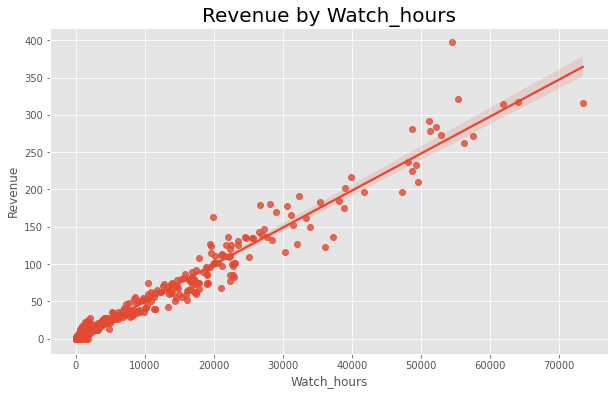

In [15]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='Watch_hours', y='Revenue')
plt.title('Revenue by Watch_hours', fontsize=20)
plt.show()

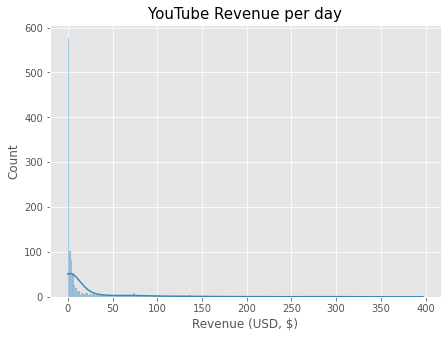

In [16]:
plt.figure(figsize=(7,5))
sns.histplot(df['Revenue'], kde=True)
plt.title('YouTube Revenue per day', fontsize=15)
plt.xlabel('Revenue (USD, $)')
plt.show()

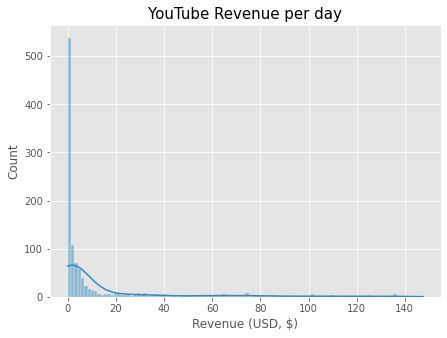

In [17]:
df = df[(df['Revenue'] <= 150)].reset_index(drop=True)
plt.figure(figsize=(7,5))
sns.histplot(df['Revenue'], kde=True)
plt.title('YouTube Revenue per day', fontsize=15)
plt.xlabel('Revenue (USD, $)')
plt.show()

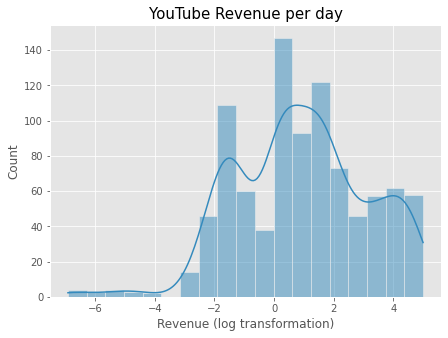

In [18]:
plt.figure(figsize=(7,5))
sns.histplot(np.log(df['Revenue']), kde=True)
plt.title('YouTube Revenue per day', fontsize=15)
plt.xlabel('Revenue (log transformation)')
plt.show()

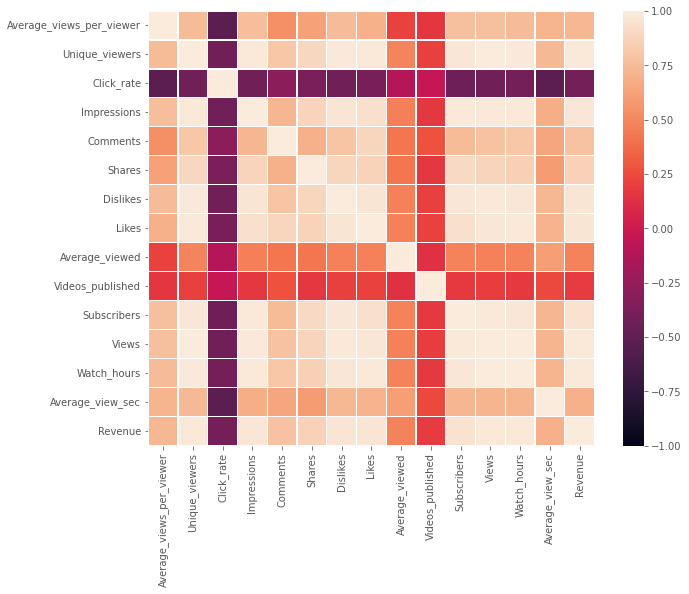

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), vmin=-1, vmax=1, linewidths=.2)
plt.show()

In [20]:
df.describe().loc[['mean', 'std', 'min', '50%', 'max']]

,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue
mean,1.614731,18141.957234,6.616151,6.165458e+05,133.624204,87.180164,29.328480,1760.494995,28.441228,0.138308,380.376706,37299.474067,2710.063589,179.736124,13.229895
std,0.321479,33306.404588,2.259077,1.345969e+06,302.549886,192.646676,54.560777,3747.027020,5.768121,0.429955,683.353242,74876.404616,5858.248179,56.878049,27.814934
min,1.000000,8.000000,3.520000,4.400000e+01,0.000000,0.000000,-1.000000,-1.000000,10.950000,0.000000,-8.000000,8.000000,0.115200,51.000000,0.000000
50%,1.545200,3652.000000,6.140000,6.588600e+04,26.000000,20.000000,5.000000,244.000000,27.800000,0.000000,111.000000,5792.000000,273.117200,174.000000,1.438000
max,2.615800,182161.000000,23.140000,6.615916e+06,3642.000000,2233.000000,284.000000,28326.000000,62.190000,4.000000,3665.000000,403655.000000,37234.927900,367.000000,147.525000


In [21]:
df.to_csv('/content/drive/MyDrive/Ai07_S2_Project/Data_youtube/2018-2019 Data.csv')

# Feature Engineering
_________


In [22]:
df.head(2)

,Date,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,111,0.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,0.0,4.0,37.0,0.9575,93,0.0


In [23]:
Subs = df.Subscribers.values.tolist()
Subs_accumulated = []
count = 0
for s in Subs:
    count += s
    Subs_accumulated.append(count)

In [24]:
df['Subs_accumulated'] = Subs_accumulated
df.head(2)

,Date,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue,Subs_accumulated
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,111,0.0,5.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,0.0,4.0,37.0,0.9575,93,0.0,9.0


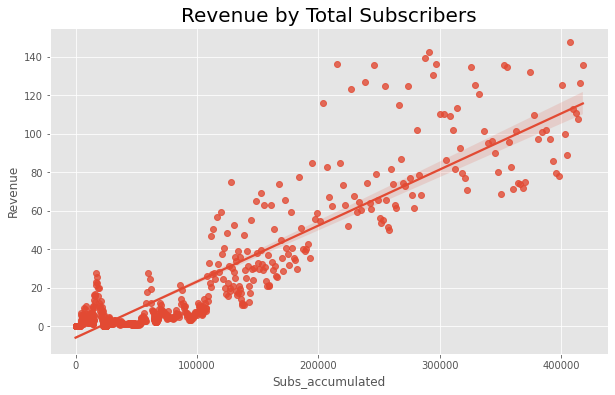

In [25]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='Subs_accumulated', y='Revenue')
plt.title('Revenue by Total Subscribers', fontsize=20)
plt.show()

In [26]:
Video_pub = df.Videos_published.values.tolist()
Videos = []
count = 0
for v in Video_pub:
    count += v
    Videos.append(count)

In [27]:
df['Videos'] = Videos
df.head(2)

,Date,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue,Subs_accumulated,Videos
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,111,0.0,5.0,1.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,0.0,4.0,37.0,0.9575,93,0.0,9.0,1.0


In [28]:
df.Videos_published.value_counts()

0.0    974
1.0    105
2.0     15
3.0      3
4.0      2
Name: Videos_published, dtype: int64

In [29]:
df['Videos_published'] = df.Videos_published.mask((df.Videos_published>0), 1).astype('int')

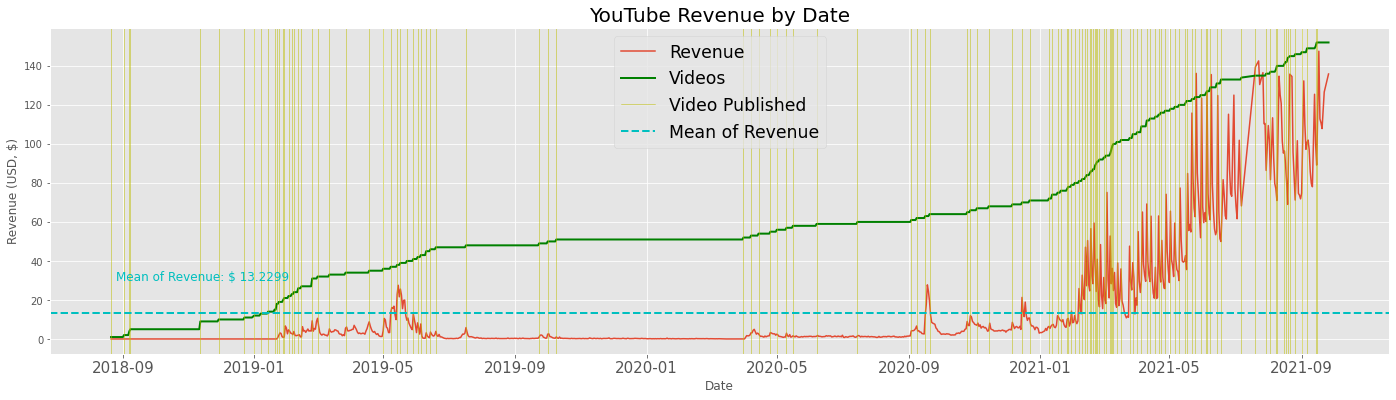

In [30]:
f, ax = plt.subplots(1, 1, figsize=(24, 6))

ax = sns.lineplot(data=df, x='Date', y='Revenue', label='Revenue', lw=1.5)
ax = sns.lineplot(data=df, x='Date', y='Videos', label='Videos', color='g', lw=2, linestyle='-')
plt.axvline(df.Date[0], color='y', label='Video Published', lw=0.5)

for i in range(1, len(df)):
    if df.Videos_published[i] == 1:
        plt.axvline(df.Date[i], color='y', lw=0.5)

plt.axhline(df.Revenue.mean(), color='c', linestyle='--', linewidth=2, label='Mean of Revenue')
plt.annotate('Mean of Revenue: $ {}'.format(round(df.Revenue.mean(),4)), 
             (df.Date[5], 30), 
             fontsize=12, 
             color='c')

plt.title('YouTube Revenue by Date', fontsize=20)
plt.ylabel('Revenue (USD, $)')
plt.xticks(fontsize=15)
ax.legend(fontsize='xx-large')
plt.show()

In [31]:
df = df[(df['Date'] > '20200901')].reset_index(drop=True)
df

,Date,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue,Subs_accumulated,Videos
0,2020-09-02,1.7296,3565.0,5.69,82419.0,40.0,32.0,3.0,344.0,23.68,0,195.0,6166.0,305.4844,178,1.532,53582.0,60.0
1,2020-09-03,1.6349,9602.0,6.96,162769.0,183.0,40.0,11.0,1602.0,30.79,1,268.0,15698.0,910.9613,208,4.096,53850.0,61.0
2,2020-09-04,1.6092,9930.0,6.89,182250.0,78.0,55.0,13.0,997.0,28.86,0,277.0,15979.0,854.6027,192,4.233,54127.0,61.0
3,2020-09-05,1.6086,12425.0,6.86,231165.0,56.0,62.0,29.0,1115.0,28.39,0,342.0,19987.0,1038.3357,187,4.248,54469.0,61.0
4,2020-09-06,1.5435,14690.0,6.96,264697.0,69.0,62.0,27.0,1322.0,28.87,0,453.0,22674.0,1177.9374,187,4.607,54922.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2021-09-18,2.3484,113363.0,3.90,4995859.0,540.0,539.0,197.0,12117.0,38.75,0,2173.0,266218.0,20999.7588,283,112.856,409854.0,152.0
353,2021-09-19,2.3207,112822.0,3.72,5140093.0,558.0,441.0,178.0,11353.0,37.68,0,2222.0,261821.0,20159.2703,277,110.829,412076.0,152.0
354,2021-09-20,2.3670,98239.0,3.78,4509271.0,425.0,453.0,163.0,9536.0,37.28,0,1997.0,232530.0,17900.4225,277,107.846,414073.0,152.0
355,2021-09-22,2.2721,105872.0,4.04,4376635.0,546.0,399.0,195.0,10594.0,25.75,0,1809.0,240554.0,19512.3516,292,126.600,415882.0,152.0


### Check Variance Inflation Factor for Colinearity

In [32]:
from sklearn.linear_model import LinearRegression

def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [33]:
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', 'green')]
}

In [34]:
df.corr()['Revenue'].sort_values(ascending=False).reset_index().style.set_table_styles([cell_hover])

,index,Revenue
0,Revenue,1.000000
1,Unique_viewers,0.977431
2,Views,0.975850
3,Watch_hours,0.972490
4,Impressions,0.962151
5,Dislikes,0.948283
6,Likes,0.944926
7,Subscribers,0.933396
8,Subs_accumulated,0.896805
9,Videos,0.882060


In [35]:
df.corr()['Revenue'].sort_values(ascending=False).reset_index()['index'][1:14].values

array(['Unique_viewers', 'Views', 'Watch_hours', 'Impressions',
       'Dislikes', 'Likes', 'Subscribers', 'Subs_accumulated', 'Videos',
       'Shares', 'Average_views_per_viewer', 'Average_view_sec',
       'Comments'], dtype=object)

In [36]:
features_chosen=[
                #  'Watch_hours', 
                #  'Unique_viewers', 
                #  'Views', 
                #  'Likes', 
                #  'Dislikes',
                #  'Impressions', 
                 'Subs_accumulated',
                #  'Subscribers', 
                 'Comments', 
                 'Shares',
                #  'Videos',
                 'Average_view_sec', 
                #  'Average_views_per_viewer', 
                 'Average_viewed'
                 ]
calculate_vif(df.iloc[:,1:], features=features_chosen).style.apply(lambda x: ['background:green' if v < 0.2 else '' for v in x], axis=1)

,VIF,Tolerance
Subs_accumulated,3.218636,0.310691
Comments,2.400777,0.416532
Shares,3.177016,0.314761
Average_view_sec,3.074383,0.325269
Average_viewed,1.783906,0.560568


In [37]:
# cols_remove = [
#                'Average_views_per_viewer', 
#                 'Watch_hours', 
#                 'Unique_viewers', 
#                 'Views', 
#                 'Likes', 
#                 'Dislikes',
#                 'Impressions',
#                 'Subs_accumulated', 
#                 'Date']

cols_remove = [
                    'Date',
                # 'Watch_hours', 
                #  'Unique_viewers', 
                #  'Views', 
                 'Dislikes',
                #  'Impressions', 
                 'Subscribers', 
                 'Comments', 
                 'Shares',
                 'Videos',
                 'Average_view_sec', 
                 'Average_views_per_viewer', 
                 'Average_viewed',
                 'Videos_published',
                 'Click_rate', 
            #    'Subs_accumulated',
                 ]


df_new = df.copy()
df_new = df_new.drop(cols_remove, axis=1)
print('New Data Shape: ', df_new.shape)
df_new.head(2)

New Data Shape:  (357, 7)


,Unique_viewers,Impressions,Likes,Views,Watch_hours,Revenue,Subs_accumulated
0,3565.0,82419.0,344.0,6166.0,305.4844,1.532,53582.0
1,9602.0,162769.0,1602.0,15698.0,910.9613,4.096,53850.0


In [38]:
df_new.corr()['Revenue']

Unique_viewers      0.977431
Impressions         0.962151
Likes               0.944926
Views               0.975850
Watch_hours         0.972490
Revenue             1.000000
Subs_accumulated    0.896805
Name: Revenue, dtype: float64

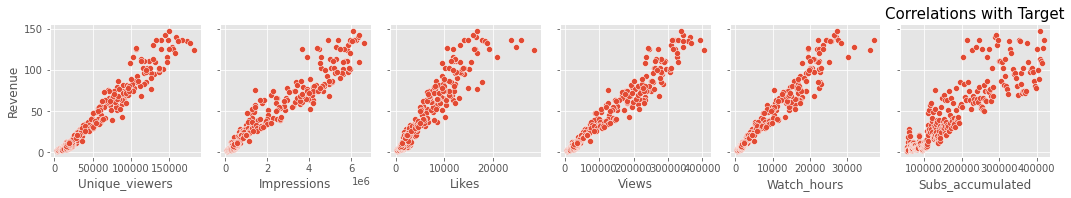

In [39]:
sns.pairplot(df_new, x_vars=df_new.columns.drop('Revenue'), y_vars=['Revenue'])
plt.title('Correlations with Target', fontsize=15)
plt.show()

# Split Data
_________

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
# train, test = train_test_split(df_new, test_size=0.2, random_state=33)

# train.shape, test.shape

In [42]:
train = df_new[:int(len(df_new)*0.8)]
test = df_new[int(len(df_new)*0.8):]
train.shape, test.shape

((285, 7), (72, 7))

In [43]:
target = 'Revenue'

X_train = train.drop(target, axis=1)
y_train = train[target]
X_test = test.drop(target, axis=1)
y_test = test[target]

X_train.shape, y_train.shape

((285, 6), (285,))

### F-statistic & P-Values

In [44]:
from sklearn.feature_selection import f_regression

pvalue_table = pd.DataFrame(f_regression(X_train, y_train), columns=X_train.columns).T.rename(columns={0:'F_statistic', 1:'p_values'})
pvalue_table.style.apply(lambda x: ["background: green" if v < 0.05 else "" for v in x], axis = 1)

,F_statistic,p_values
Unique_viewers,6222.843772,0.000000
Impressions,1876.512061,0.000000
Likes,3073.756391,0.000000
Views,4103.723499,0.000000
Watch_hours,4466.619683,0.000000
Subs_accumulated,662.696705,0.000000


# BaseLine Model
_____

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [46]:
def evaluate(title, y, y_):
    mae = mean_absolute_error(y, y_)
    rmse = mean_squared_error(y, y_)**0.5
    r2 = r2_score(y, y_)
    print('*{} Result*'.format(title))
    print('='*50)
    print('MAE Score: $', mae)
    print('RMSE Score: $', rmse)
    print('R2 Score: ', r2)
    print()

### Linear Regression

In [47]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [48]:
pipe_lin = make_pipeline(
    StandardScaler(),
    LinearRegression(n_jobs=-1)
)

pipe_lin.fit(X_train, y_train)
y_pred = np.exp(pipe_lin.predict(X_test))
evaluate('Linear Regression', y_test, y_pred)

*Linear Regression Result*
MAE Score: $ 2.421656778817104e+58
RMSE Score: $ 1.9909852746570334e+59
R2 Score:  -6.416492784980832e+115



### Log Transformed Linear Regression

In [49]:
from sklearn.compose import TransformedTargetRegressor

In [50]:
tt_lin = TransformedTargetRegressor(regressor=pipe_lin,
                                func=np.log1p, inverse_func=np.expm1)

tt_lin.fit(X_train, y_train)
y_pred = tt_lin.predict(X_test)
evaluate('Log Transformed Linear Regression', y_test, y_pred)

*Log Transformed Linear Regression Result*
MAE Score: $ 717.94677550589
RMSE Score: $ 1319.0606403386962
R2 Score:  -2815.3792592741856



# Model Selection
_____

### Ridge

In [51]:
pipe_ridge = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=np.arange(100, 105, 0.01), cv=5)
)

tt_ridge = TransformedTargetRegressor(regressor=pipe_ridge,
                                func=np.log1p, inverse_func=np.expm1)

tt_ridge.fit(X_train, y_train)
y_pred = tt_ridge.predict(X_test)
print('Best alpha: ', tt_ridge.regressor_.named_steps['ridgecv'].alpha_)
evaluate('Log Transformed Ridge', y_test, y_pred)

Best alpha:  104.99000000000255
*Log Transformed Ridge Result*
MAE Score: $ 132.3107254998166
RMSE Score: $ 177.49102113626378
R2 Score:  -49.993449385099346



### Lasso

In [52]:
pipe_lasso = make_pipeline(
    StandardScaler(),
    LassoCV(alphas=np.arange(0, 0.2, 0.001), cv=5, random_state=33)
)

tt_lasso = TransformedTargetRegressor(regressor=pipe_lasso,
                                func=np.log1p, inverse_func=np.expm1)

tt_lasso.fit(X_train, y_train)
y_pred = tt_lasso.predict(X_test)
print('Best alpha: ', tt_lasso.regressor_.named_steps['lassocv'].alpha_)
evaluate('Log Transformed Lasso', y_test, y_pred)

Best alpha:  0.165
*Log Transformed Lasso Result*
MAE Score: $ 99.75309607517283
RMSE Score: $ 135.58598605468856
R2 Score:  -28.75714231645207



### ElasticNet

In [53]:
from sklearn.linear_model import ElasticNetCV

In [54]:
pipe_elnet = make_pipeline(
    StandardScaler(),
    ElasticNetCV(n_jobs=-1, cv=5, random_state=33)
)

tt_elnet = TransformedTargetRegressor(regressor=pipe_elnet,
                                func=np.log1p, inverse_func=np.expm1)

tt_elnet.fit(X_train, y_train)
y_pred = tt_elnet.predict(X_test)
evaluate('Log Transformed ElasticNet', y_test, y_pred)

*Log Transformed ElasticNet Result*
MAE Score: $ 91.33615311853114
RMSE Score: $ 121.91817963713234
R2 Score:  -23.060162347336234



### RandomForest Regressor

In [55]:
from sklearn.ensemble import RandomForestRegressor

In [56]:
pipe_rfreg = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=33)
)

tt_rfreg = TransformedTargetRegressor(regressor=pipe_rfreg,
                                func=np.log1p, inverse_func=np.expm1)

tt_rfreg.fit(X_train, y_train)
y_pred = tt_rfreg.predict(X_test)
evaluate('Log Transformed RandomForest Regressor', y_test, y_pred)

*Log Transformed RandomForest Regressor Result*
MAE Score: $ 17.13914481924245
RMSE Score: $ 20.681755696247517
R2 Score:  0.3076329018138705



### XGB Regressor

In [57]:
from xgboost import XGBRegressor

In [58]:
pipe_xgb = make_pipeline(
    StandardScaler(),
    XGBRegressor(learning_rate=0.1,
                  n_estimators=500,
                  n_jobs=-1,
                  random_state=33)
)

tt_xgb = TransformedTargetRegressor(regressor=pipe_xgb,
                                func=np.log1p, inverse_func=np.expm1)

tt_xgb.fit(X_train, y_train)
y_pred = tt_xgb.predict(X_test)
evaluate('Log Transformed XGB Regressor', y_test, y_pred)

[11:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
*Log Transformed XGB Regressor Result*
MAE Score: $ 10.284579527113173
RMSE Score: $ 13.516364680138228
R2 Score:  0.7042795108581279



### Light Gradient Boost Machine Regressor

In [59]:
from lightgbm import LGBMRegressor

In [60]:
pipe_lgb = make_pipeline(
    StandardScaler(),
    LGBMRegressor(learning_rate=0.1,
                  n_estimators=500,
                  n_jobs=-1,
                  random_state=33)
)

tt_lgb = TransformedTargetRegressor(regressor=pipe_lgb,
                                func=np.log1p, inverse_func=np.expm1)

tt_lgb.fit(X_train, y_train)
y_pred = tt_lgb.predict(X_test)
evaluate('Log Transformed Light GBM Regressor', y_test, y_pred)

*Log Transformed Light GBM Regressor Result*
MAE Score: $ 16.93779744962932
RMSE Score: $ 21.102087949679866
R2 Score:  0.2792038275446359



### Model Combined

In [61]:
y_pred = tt_rfreg.predict(X_test)*0.1 + tt_xgb.predict(X_test)*0.8 + + tt_lgb.predict(X_test)*0.1
evaluate('[RF + XGB]', y_test, y_pred)

*[RF + XGB] Result*
MAE Score: $ 10.115426961484465
RMSE Score: $ 13.154020503534591
R2 Score:  0.7199222278537214



# Visualization
____

### LinearRegression, Ridge, Lasso, ElasticNet

In [62]:
def get_top_bottom_coef(model):
    coef = pd.Series(model.coef_, index=X_train.columns).sort_values(ascending=False)
    return coef

def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(20, 6), nrows=1, ncols=4)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef = get_top_bottom_coef(model)
        axs[i_num].set_title(model.__class__.__name__+ ' Coefficients', size=20)
        axs[i_num].tick_params(axis='y', direction='in', pad=0)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(13)
        sns.barplot(x=coef.values,
                   y=coef.index, ax=axs[i_num])
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=1, 
                    wspace=0.8, 
                    hspace=0.4)

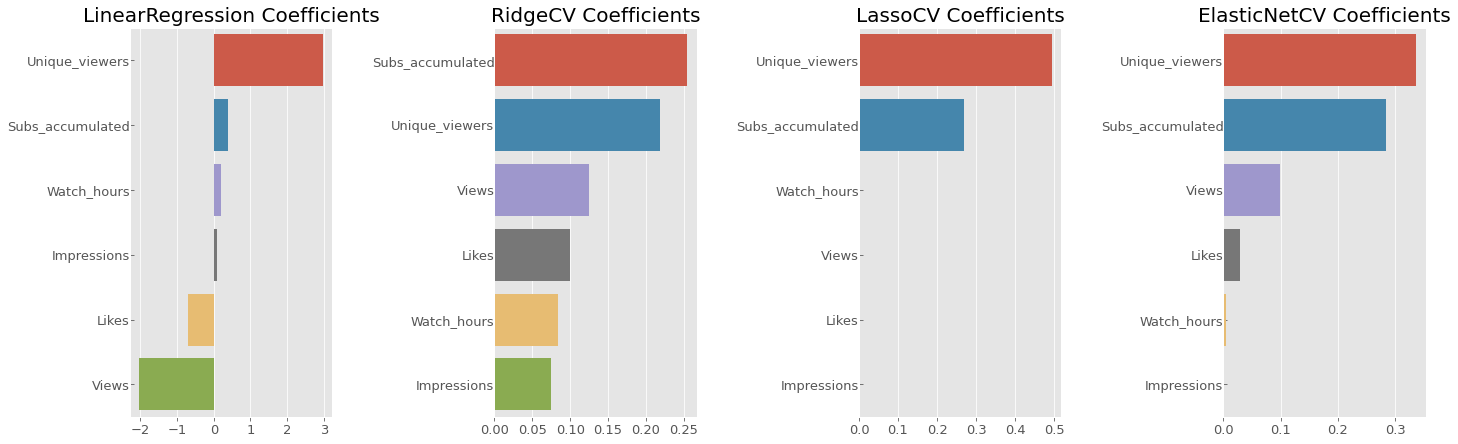

In [63]:
lin = tt_lin.regressor_.named_steps['linearregression']
ridge = tt_ridge.regressor_.named_steps['ridgecv']
lasso = tt_lasso.regressor_.named_steps['lassocv']
elnet = tt_elnet.regressor_.named_steps['elasticnetcv']
models = [lin, ridge, lasso, elnet]

visualize_coefficient(models)

### Tree-based Regressor

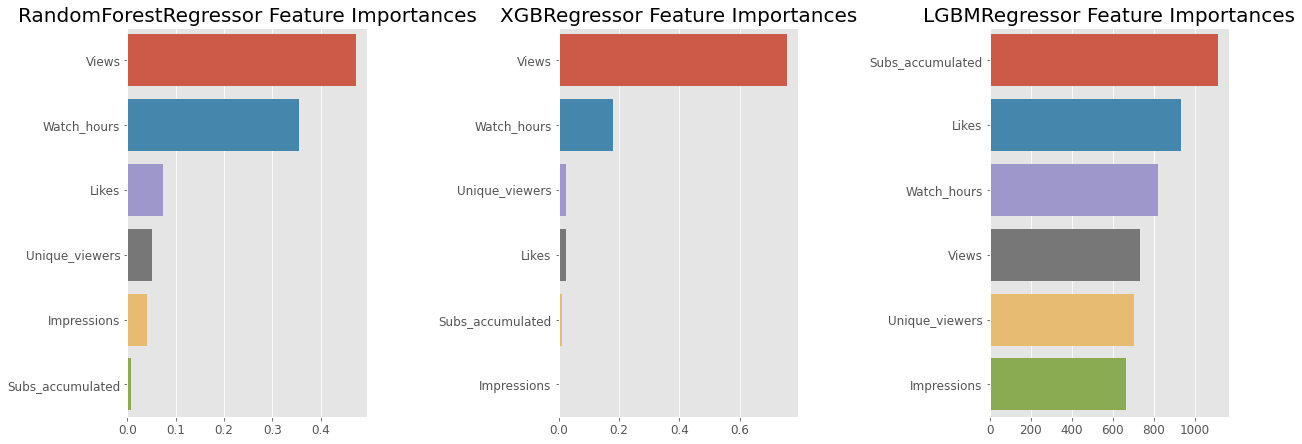

In [64]:
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
    ftr_top = ftr_importances.sort_values(ascending=False)
    return ftr_top

def visualize_ftr_importances(models):
    fig, axs = plt.subplots(figsize=(17,6), nrows=1, ncols=3)
    fig.tight_layout() 
    for i_num, model in enumerate(models):
        ftr_top = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=20)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(12)
        sns.barplot(x=ftr_top.values, y=ftr_top.index , ax=axs[i_num])
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=1, 
                    wspace=0.8, 
                    hspace=0.4)

rf = tt_rfreg.regressor_.named_steps['randomforestregressor']
xgb = tt_xgb.regressor_.named_steps['xgbregressor']
lgbm = tt_lgb.regressor_.named_steps['lgbmregressor']

models = [rf, xgb, lgbm]
visualize_ftr_importances(models)

# Hyperparameters
_____

In [65]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [66]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [67]:
rf_reg = RandomForestRegressor(n_estimators=100,
                               n_jobs=-1,
                               random_state=33)

xgb_reg = XGBRegressor(n_estimators=100,
                       n_jobs=-1,
                       random_state=33,
                       seed=33)

lgb_reg = LGBMRegressor(n_estimators=100,
                        n_jobs=-1,
                        random_state=33)

In [68]:
def randcv(estimator, params):
    randcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions=params,
                                n_iter=5,
                                scoring='neg_root_mean_squared_error',
                                cv=3,
                                random_state=33,
                                n_jobs=-1)

    tt = TransformedTargetRegressor(regressor=randcv,
                                func=np.log1p, inverse_func=np.expm1)

    tt.fit(X_train, y_train)
    y_pred = tt.predict(X_test)

    print('Best Params: ', tt.regressor_.best_params_)
    evaluate(estimator.__class__.__name__, y_test, y_pred)

    return tt.regressor_.best_estimator_

In [69]:
def gridcv(estimator, params):
    gridcv = GridSearchCV(estimator=estimator,
                          param_grid=params,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          n_jobs=-1)

    tt = TransformedTargetRegressor(regressor=gridcv,
                                func=np.log1p, inverse_func=np.expm1)

    tt.fit(X_train, y_train)
    y_pred = tt.predict(X_test)

    print('Best Params: ', tt.regressor_.best_params_)
    evaluate(estimator.__class__.__name__, y_test, y_pred)
    
    return tt.regressor_.best_estimator_

### RandomForest Hyperparameters

In [70]:
params_rf = {'max_depth': [18], 
             'min_samples_split': [6], 
             'min_samples_leaf': [1]
             }
# randcv_rf = randcv(rf_reg, params_rf)
gridcv_rf = gridcv(rf_reg, params_rf)

Best Params:  {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 6}
*RandomForestRegressor Result*
MAE Score: $ 17.065274546431933
RMSE Score: $ 20.49967373091646
R2 Score:  0.3197704219595958



In [71]:
pipe_rfreg = make_pipeline(
    # StandardScaler(),
    RandomForestRegressor(n_estimators=16,
                          min_samples_split=6,
                          min_samples_leaf=5,
                          max_depth=21, 
                          n_jobs=-1,
                          oob_score=True, 
                          random_state=33)
)

tt_rfreg = TransformedTargetRegressor(regressor=pipe_rfreg,
                                func=np.log1p, inverse_func=np.expm1)

tt_rfreg.fit(X_train, y_train)
y_pred = tt_rfreg.predict(X_test)
print('OOB Score: ', tt_rfreg.regressor_.named_steps['randomforestregressor'].oob_score_)
print('='*50)
evaluate('Log Transformed RandomForest Regressor for Training Set', y_train, tt_rfreg.predict(X_train))
evaluate('Log Transformed RandomForest Regressor for Test Set', y_test, y_pred)

OOB Score:  0.9737297405868751
*Log Transformed RandomForest Regressor for Training Set Result*
MAE Score: $ 2.2272729910562146
RMSE Score: $ 4.509685982620201
R2 Score:  0.96735169127833

*Log Transformed RandomForest Regressor for Test Set Result*
MAE Score: $ 19.38918691408541
RMSE Score: $ 22.192555089480987
R2 Score:  0.2027835939968573



### XGBoost Hyperparameters

In [72]:
params_xgb = {
              'max_depth':[3], 
              'learning_rate':[0.001, 0.01, 0.1, 0.15], 
            }

# randcv(xgb_reg, params_xgb)
gridcv(xgb_reg, params_xgb)

[11:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Params:  {'learning_rate': 0.15, 'max_depth': 3}
*XGBRegressor Result*
MAE Score: $ 11.8223601053026
RMSE Score: $ 15.252176264431181
R2 Score:  0.6234477512456359



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=33,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=33,
             silent=None, subsample=1, verbosity=1)

In [73]:
xgb_reg = XGBRegressor(n_estimators=1000,
                       learning_rate=0.1,
                       max_depth=3,
                       n_jobs=-1,
                       random_state=33,
                       seed=33)

tt_xgb = TransformedTargetRegressor(regressor=xgb_reg,
                                func=np.log1p, inverse_func=np.expm1)

tt_xgb.fit(X_train, y_train,
        verbose=False,
        early_stopping_rounds=100,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse')
y_pred = tt_xgb.predict(X_test)
evaluate('Log Transformed XGB Regressor for Training Set', y_train, tt_xgb.predict(X_train))
evaluate('Log Transformed XGB Regressor for Test Set', y_test, y_pred)

[11:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
*Log Transformed XGB Regressor for Training Set Result*
MAE Score: $ 0.3933550020853677
RMSE Score: $ 0.6605025373494122
R2 Score:  0.9992996468850244

*Log Transformed XGB Regressor for Test Set Result*
MAE Score: $ 10.016284430609808
RMSE Score: $ 13.333539477369117
R2 Score:  0.7122253618745451



In [74]:
y_true = y_test.reset_index().copy()
y_true['y_pred'] = y_pred
y_true

,index,Revenue,y_pred
0,285,55.193,47.596016
1,286,124.797,121.388908
2,287,65.471,65.956711
3,288,51.422,49.759037
4,289,49.960,42.471889
...,...,...,...
67,352,112.856,91.371178
68,353,110.829,91.371178
69,354,107.846,84.425385
70,355,126.600,88.192291


### LightGBM Hyperparameters

In [75]:
params_lgb = {
              'num_leaves':[29], 
              'max_depth':[-1], 
              'learning_rate':[0.1], 
              }

# randcv(lgb_reg, params_lgb)
gridcv(lgb_reg, params_lgb)

Best Params:  {'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 29}
*LGBMRegressor Result*
MAE Score: $ 17.74309652582346
RMSE Score: $ 22.379713097378897
R2 Score:  0.18928045422268436



LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=29, objective=None,
              random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [76]:
lgb_reg = LGBMRegressor(n_estimators=1000,
                        num_leaves=11,
                        max_depth=-1,
                        learning_rate=0.271,
                        reg_alpha=0.0003,
                        reg_lambda=1.2,
                        n_jobs=-1,
                        objective='regression',
                        random_state=33)

tt_lgb = TransformedTargetRegressor(regressor=lgb_reg,
                                func=np.log1p, inverse_func=np.expm1)

tt_lgb.fit(X_train, y_train,
        verbose=False,
        early_stopping_rounds=100,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse')
y_pred = tt_lgb.predict(X_test)
evaluate('Log Transformed Light GBM Regressor for Training Set', y_train, tt_lgb.predict(X_train))
evaluate('Log Transformed Light GBM Regressor for Test Set', y_test, y_pred)

*Log Transformed Light GBM Regressor for Training Set Result*
MAE Score: $ 1.0395071372267508
RMSE Score: $ 5.010566988695177
R2 Score:  0.959696586566423

*Log Transformed Light GBM Regressor for Test Set Result*
MAE Score: $ 17.01107692285988
RMSE Score: $ 21.058765033328317
R2 Score:  0.28216040109400153



### Tuned Models Combined

In [77]:
y_pred = tt_rfreg.predict(X_test)*0.1 + tt_xgb.predict(X_test)*0.8 + tt_lgb.predict(X_test)*0.1
evaluate('[RF + XGB + LGBM]', y_test, y_pred)

*[RF + XGB + LGBM] Result*
MAE Score: $ 9.9590053764763
RMSE Score: $ 12.941646260397691
R2 Score:  0.7288930419392727



# Result
________

### Permutation Importance & Feature Importance

In [80]:
import eli5
from eli5.sklearn import PermutationImportance

In [81]:
from IPython.display import display

# Permutation Importance
def show_permutation_importance(model):
    prm_imps = PermutationImportance(model,
                                    scoring='neg_root_mean_squared_error',
                                    n_iter=5,
                                    random_state=33)

    prm_imps.fit(X_train, y_train)
    print('{} Permutation Importance'.format(model.__class__.__name__))
    display(eli5.show_weights(
        prm_imps,
        top=None,
        feature_names=X_train.columns.to_list()
    ))

In [82]:
show_permutation_importance(tt_rfreg)
show_permutation_importance(tt_xgb)
show_permutation_importance(tt_lgb)

TransformedTargetRegressor Permutation Importance


Weight,Feature
12.8306 ± 0.5398,Watch_hours
10.6276 ± 2.7283,Views
7.9037 ± 0.8979,Unique_viewers
6.3021 ± 0.9603,Likes
1.0248 ± 0.7400,Impressions
0.1006 ± 0.0636,Subs_accumulated


TransformedTargetRegressor Permutation Importance


Weight,Feature
18.7188 ± 0.5136,Watch_hours
9.7212 ± 1.7836,Views
9.3246 ± 0.6503,Unique_viewers
7.8331 ± 0.8269,Likes
6.2670 ± 0.8459,Subs_accumulated
0.7409 ± 0.1451,Impressions


TransformedTargetRegressor Permutation Importance


Weight,Feature
14.3178 ± 0.4634,Watch_hours
9.2226 ± 2.6723,Views
9.1115 ± 0.8834,Likes
3.7593 ± 0.6030,Impressions
1.6538 ± 0.3885,Subs_accumulated
0.7766 ± 0.2313,Unique_viewers


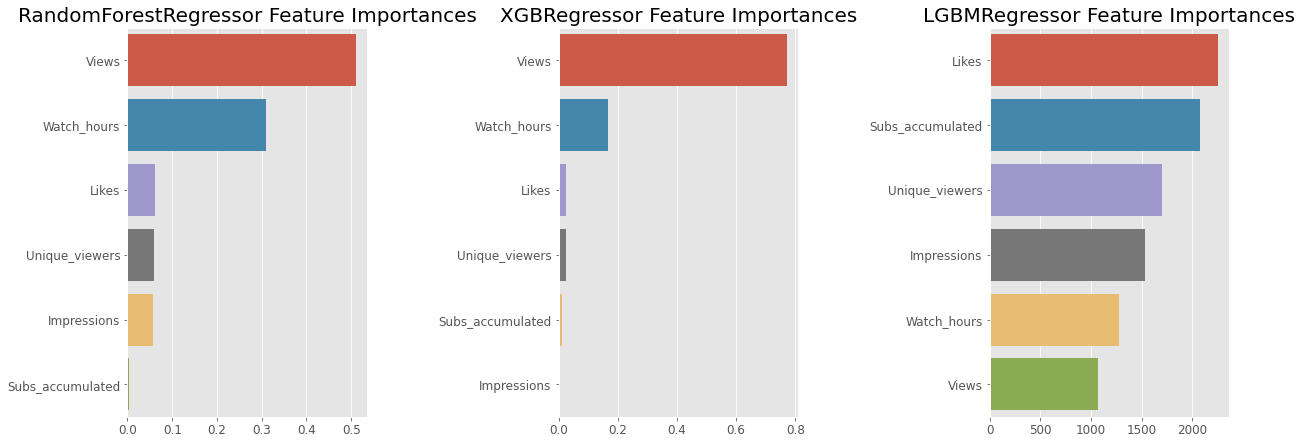

In [83]:
rf = tt_rfreg.regressor_.named_steps['randomforestregressor']
xgb = tt_xgb.regressor_
lgbm = tt_lgb.regressor_

models = [rf, xgb, lgbm]
visualize_ftr_importances(models)

### Partial Dependence Plot(PDP)

In [84]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from pdpbox import pdp
import shap

In [85]:
def draw_pdp_plot(feature, model, X_val, num_grid_points = 10):
    isolated = pdp_isolate(
        model=model,
        dataset=X_val,
        model_features=X_val.columns,
        feature=feature,
        grid_type='percentile',
        num_grid_points=num_grid_points
    )
    if model.regressor.__class__.__name__ == 'Pipeline':
        print('<<<{} MODEL>>>'.format(model.regressor.named_steps['randomforestregressor'].__class__.__name__))
    else:
        print('<<<{} MODEL>>>'.format(model.regressor.__class__.__name__))
    print('='*100)
    pdp.pdp_plot(isolated, feature)

In [86]:
features = X_train.columns.tolist()[2:-1]
features

['Likes', 'Views', 'Watch_hours']

In [87]:
X = pd.concat((X_train, X_test))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


<<<XGBRegressor MODEL>>>


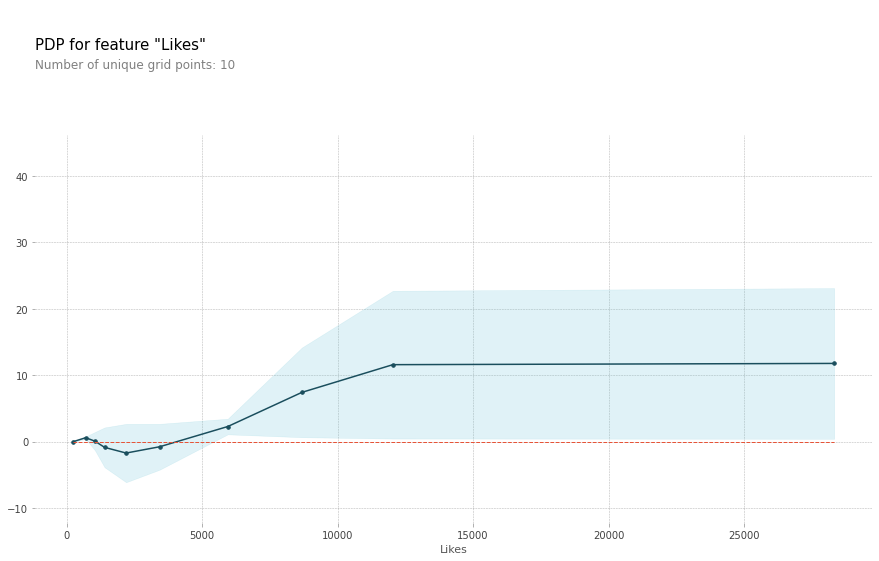

In [88]:
draw_pdp_plot(features[0], tt_xgb, X)

<<<RandomForestRegressor MODEL>>>


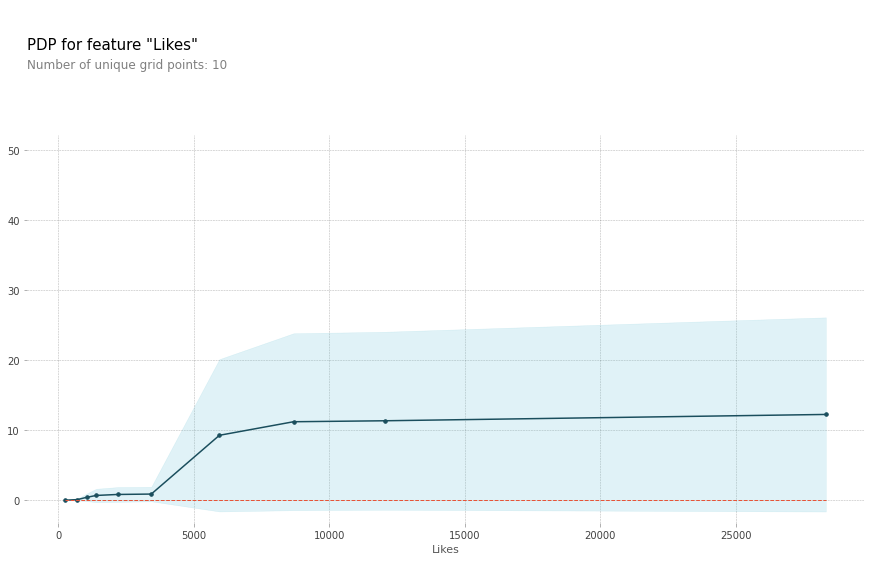

In [89]:
draw_pdp_plot(features[0], tt_rfreg, X)

<<<LGBMRegressor MODEL>>>


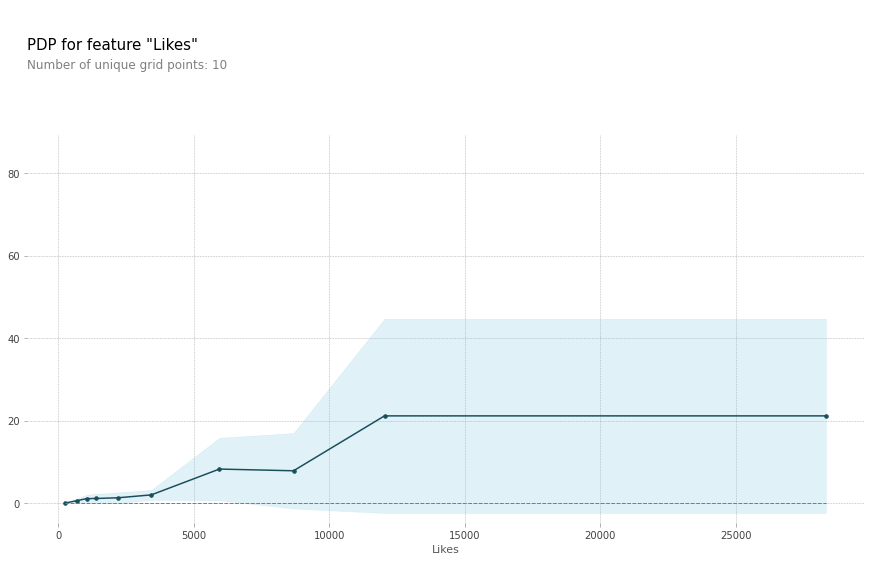

In [90]:
draw_pdp_plot(features[0], tt_lgb, X)

<<<XGBRegressor MODEL>>>


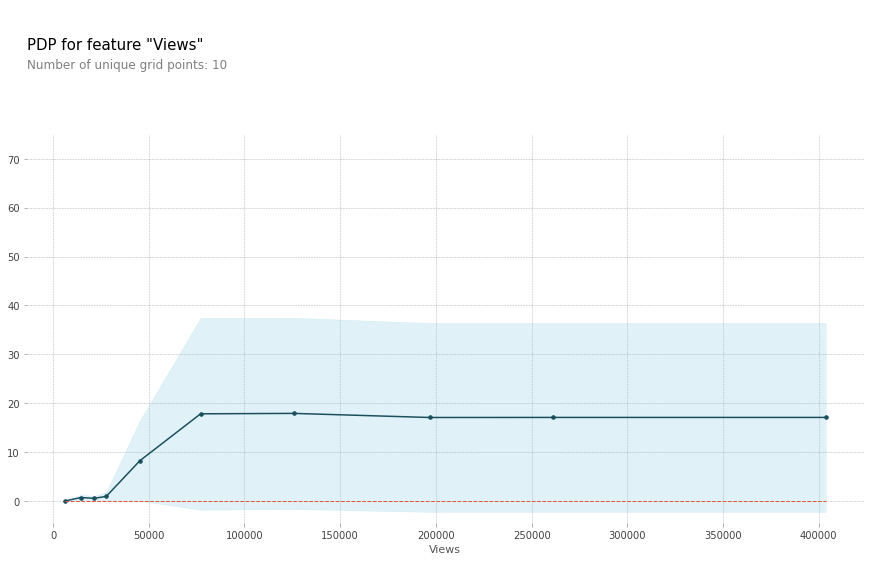

In [91]:
draw_pdp_plot(features[1], tt_xgb, X)

<<<RandomForestRegressor MODEL>>>


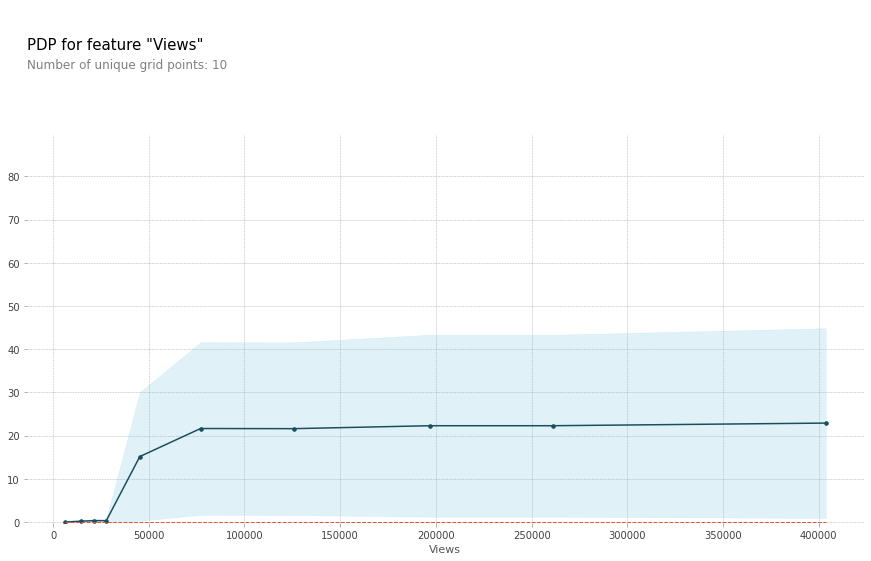

In [92]:
draw_pdp_plot(features[1], tt_rfreg, X)

<<<LGBMRegressor MODEL>>>


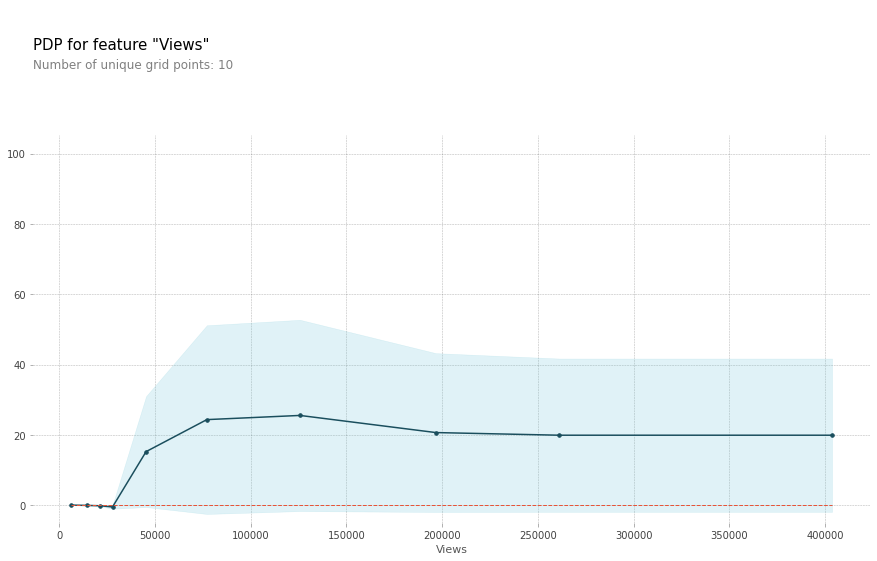

In [93]:
draw_pdp_plot(features[1], tt_lgb, X)

<<<XGBRegressor MODEL>>>


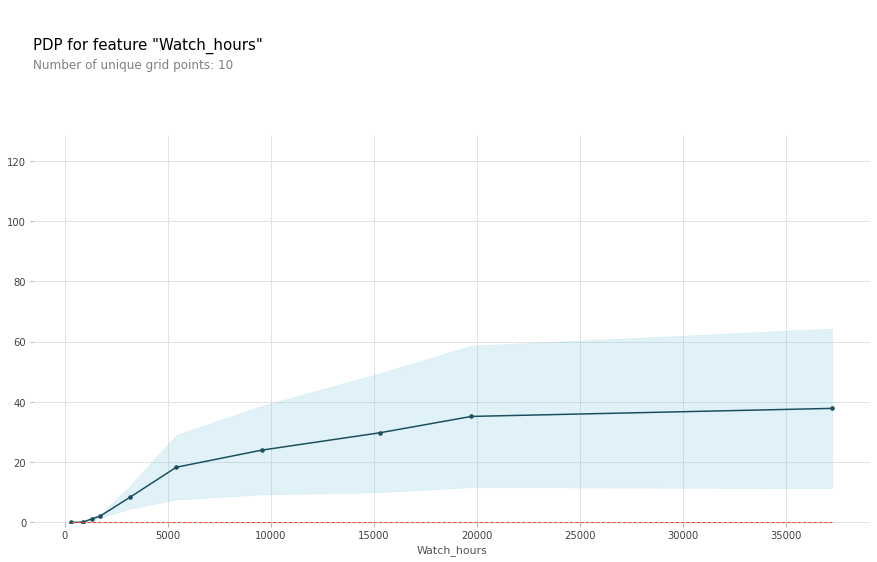

In [94]:
draw_pdp_plot(features[2], tt_xgb, X)

<<<RandomForestRegressor MODEL>>>


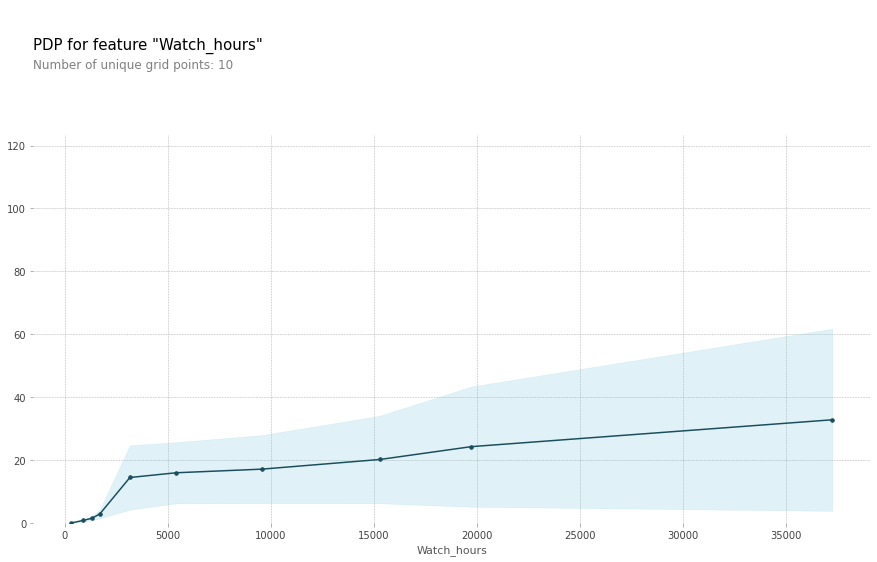

In [95]:
draw_pdp_plot(features[2], tt_rfreg, X)

<<<LGBMRegressor MODEL>>>


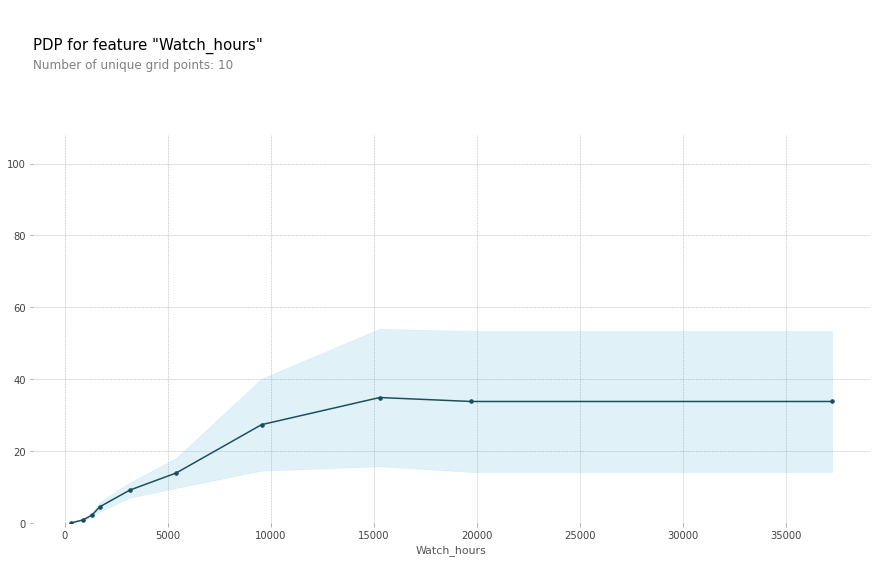

In [96]:
draw_pdp_plot(features[2], tt_lgb, X)

<<<XGBRegressor MODEL>>>


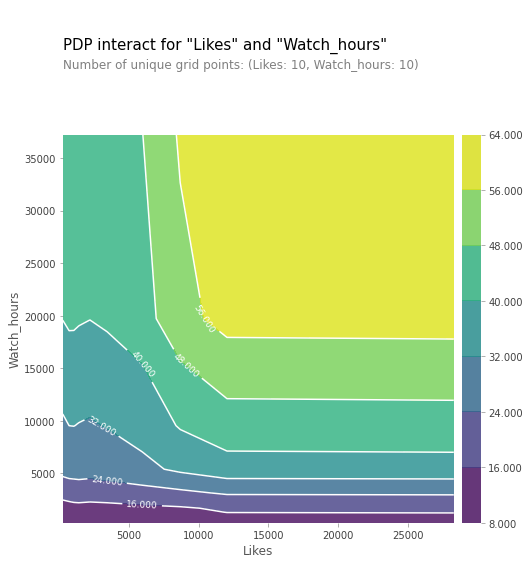

<<<RandomForestRegressor MODEL>>>


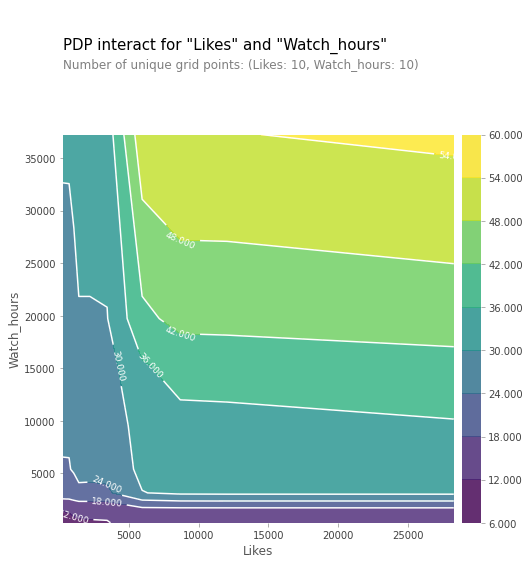

<<<LGBMRegressor MODEL>>>


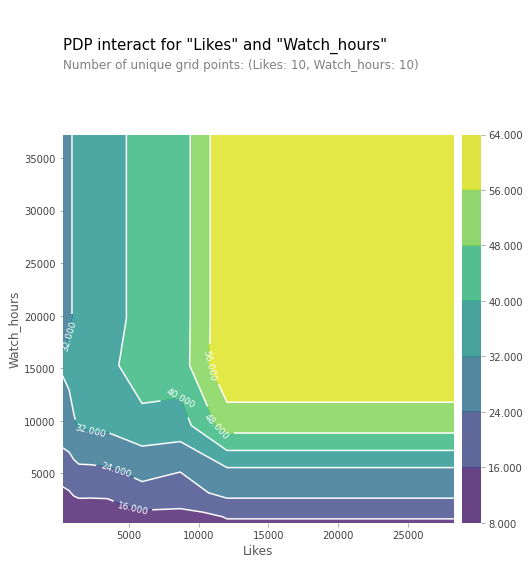

In [97]:
def draw_pdp_interaction(model, features, X_test, plot_type):
    interaction = pdp_interact(
        model=model, 
        dataset=X_test,
        model_features=X_test.columns, 
        features=features
    )
    if model.regressor.__class__.__name__ == 'Pipeline':
        print('<<<{} MODEL>>>'.format(model.regressor.named_steps['randomforestregressor'].__class__.__name__))
    else:
        print('<<<{} MODEL>>>'.format(model.regressor.__class__.__name__))
    print('='*100)
    pdp_interact_plot(interaction, plot_type=plot_type, feature_names=features)
    plt.show()

features = ['Likes', 'Watch_hours']
draw_pdp_interaction(tt_xgb, features, X, 'contour')
draw_pdp_interaction(tt_rfreg, features, X, 'contour')
draw_pdp_interaction(tt_lgb, features, X, 'contour')

<<<XGBRegressor MODEL>>>


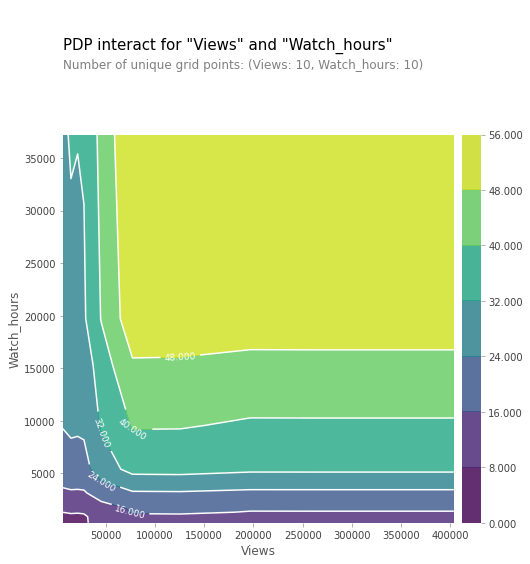

<<<RandomForestRegressor MODEL>>>


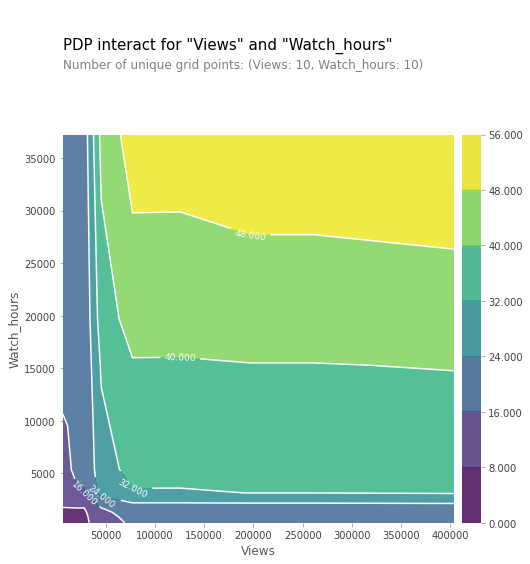

<<<LGBMRegressor MODEL>>>


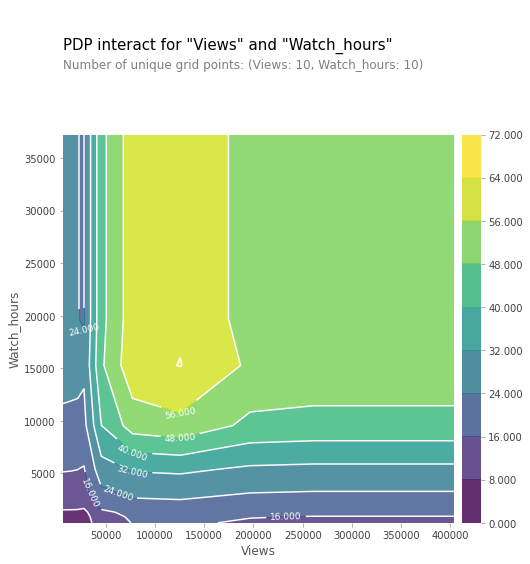

In [98]:
features = ['Views', 'Watch_hours']
draw_pdp_interaction(tt_xgb, features, X, 'contour')
draw_pdp_interaction(tt_rfreg, features, X, 'contour')
draw_pdp_interaction(tt_lgb, features, X, 'contour')

<<<XGBRegressor MODEL>>>


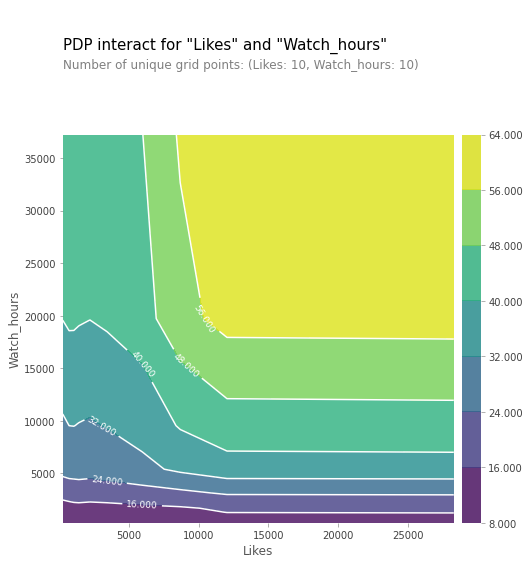

<<<RandomForestRegressor MODEL>>>


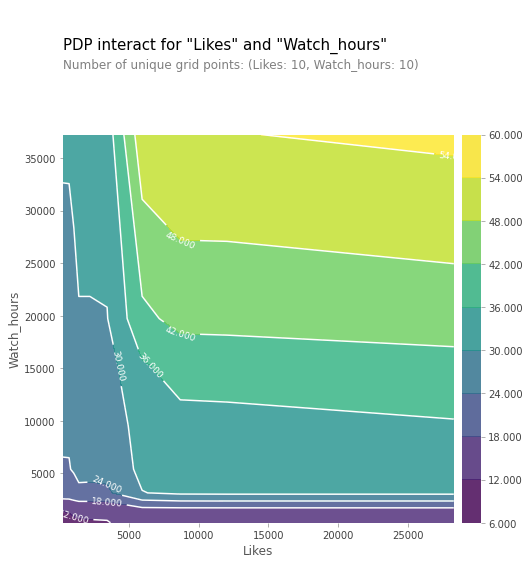

<<<LGBMRegressor MODEL>>>


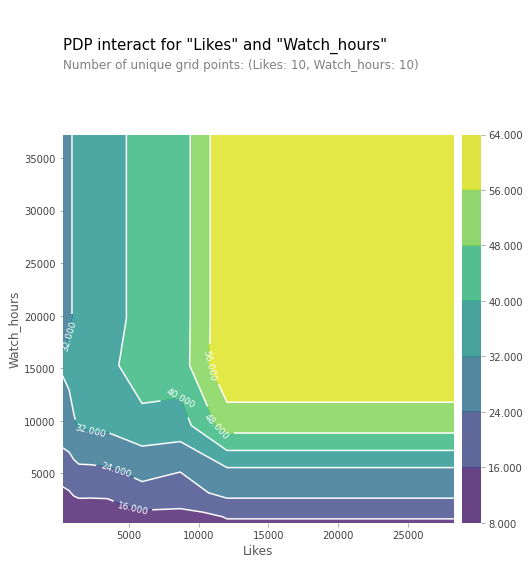

In [99]:
features = ['Likes', 'Watch_hours']
draw_pdp_interaction(tt_xgb, features, X, 'contour')
draw_pdp_interaction(tt_rfreg, features, X, 'contour')
draw_pdp_interaction(tt_lgb, features, X, 'contour')

### SHAP Values

In [100]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

In [101]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

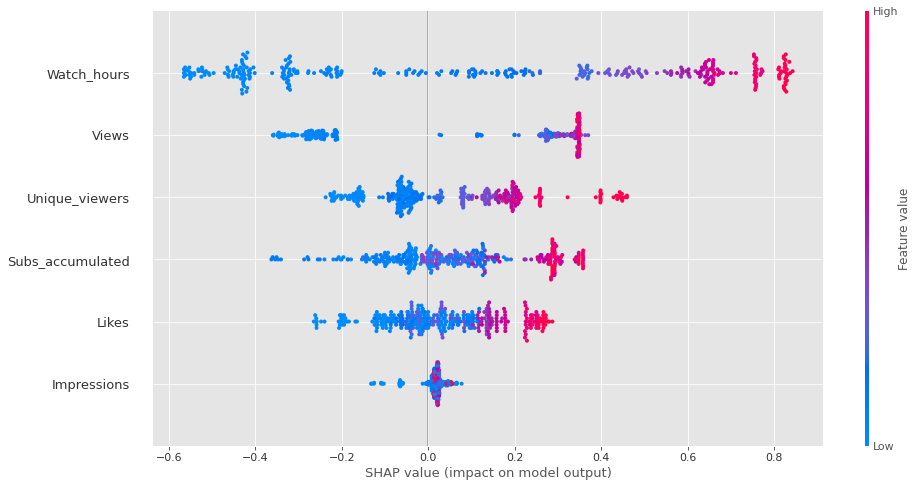

In [102]:
shap.summary_plot(shap_values, X, plot_size=(15,8))

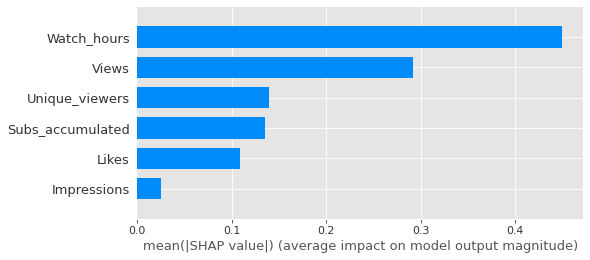

In [103]:
shap.summary_plot(shap_values, X, plot_type='bar')

In [104]:
def draw_shap_value(sample):
    explainer = shap.TreeExplainer(xgb)
    shap.initjs()
    samp_df = pd.DataFrame(dict(zip(X_test.columns, np.array(sample).reshape(-1,1))))
    display(shap.force_plot(explainer.expected_value, explainer.shap_values(samp_df.iloc[0]), samp_df.iloc[0]))
    y_pred = np.exp(xgb.predict(samp_df))[0]
    base_value = np.exp(explainer.expected_value)
    samp_df.loc[1] = explainer.shap_values(samp_df.iloc[0])[0].tolist()
    samp_df.index = ['YouTuber\'s Info', 'SHAP values']
    display(samp_df.style.apply(lambda x: ['background: red' if v>0 else 'background: blue' for v in x], axis=0))
    print('Average YouTube Daily Revenue: $ {}'.format(base_value))
    print('Predicted YouTube Daily Revenue: $ {}'.format(y_pred))

In [105]:
import random

sample = [round(random.uniform(10000,500000)),
          round(random.uniform(100000,10226681)),
          round(random.uniform(1000,40326)),
          round(random.uniform(10000,503655)),
          round(random.uniform(3000,40000), 4),
          round(random.uniform(2000,500000))]
draw_shap_value(sample)

,Unique_viewers,Impressions,Likes,Views,Watch_hours,Subs_accumulated
YouTuber's Info,247777.000000,5078066.000000,13760.000000,87040.000000,10743.044200,147737.000000
SHAP values,0.355634,0.017303,0.259181,0.367685,0.623671,0.105437


Average YouTube Daily Revenue: $ 14.584346771240234
Predicted YouTube Daily Revenue: $ 82.17532348632812


In [106]:
def pred_revenue(unique_viewers, impressions, likes, views, watch_hours, subs_accumulated):
    YouTuber_info = [unique_viewers, impressions, likes, views, watch_hours, subs_accumulated]
    draw_shap_value(YouTuber_info)

In [115]:
pred_revenue(57626.0, 2586855.0, 4954.0, 141204.0, 10312.5295, 253140.0)
print('Actual Revenue: $ {}'.format(y_test.iloc[0]))

,Unique_viewers,Impressions,Likes,Views,Watch_hours,Subs_accumulated
YouTuber's Info,57626.000000,2586855.000000,4954.000000,141204.000000,10312.529500,253140.000000
SHAP values,0.101143,0.023894,-0.028274,0.292011,0.547084,0.267737


Average YouTube Daily Revenue: $ 14.584346771240234
Predicted YouTube Daily Revenue: $ 48.59601593017578
Actual Revenue: $ 55.193000000000005
